In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from CGCNN_MT.datamodule.dataset import LoadGraphData
import matplotlib.gridspec as gridspec
from upsetplot import UpSet
import upsetplot
import yaml
import random
import re
from itertools import chain, product, combinations
from collections import defaultdict
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, StandardScaler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

In [3]:
data_root_dir = "./CGCNN_MT/data"
data_root_dir = Path(data_root_dir)
ssd_raw_csv = "./raw_data/Nandy_2022_SciData/separate_files/solvent_removal_stability/full_SSD_data.csv"
tsd_raw_csv = "./raw_data/Nandy_2022_SciData/separate_files/thermal_stability/full_TSD_data.csv"
fig_dir = "./CGCNN_MT/evaluation/figures"
fig_dir = Path(fig_dir)
fig_dir.mkdir(exist_ok=True, parents=True)

mof_name_map = {}

df_raw_ssd = pd.read_csv(ssd_raw_csv)
df_raw_tsd = pd.read_csv(tsd_raw_csv)
df_raw_ssd.dropna(inplace=True)
df_raw_tsd.dropna(inplace=True)
for df in [df_raw_ssd, df_raw_tsd]:
    for i, row in df.iterrows():
        mof_name = row["CoRE_name"]
        refcode = row["refcode"]
        if mof_name not in mof_name_map:
            mof_name_map[mof_name] = refcode
        else:
            assert mof_name_map[mof_name] == refcode, f"{mof_name} has multiple refcodes: {refcode} and {mof_name_map[mof_name]}"
print(f"total {len(df_raw_ssd) + len(df_raw_tsd)} samples")
print(f"total {len(mof_name_map)} mofs")

tasks = ["TSD", "SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]
class_map_2 = {0: "unstable", 1: "stable"}
class_map_4 = {0: "U", 1: "LK", 2: "HK", 3: "TS"}

dfs = {}
for task in tasks:
    data_dir = data_root_dir / task
    split_dfs = {}
    for split in ["train", "val", "test"]:
        dataset = LoadGraphData(data_dir, split, csv_file_name="id_prop_feat.csv")
        split_dfs[split] = dataset.id_prop_df[["Partition"] + dataset.prop_cols].copy()
        split_dfs[split].rename(columns={dataset.prop_cols[0]: "Label"}, inplace=True)
        if task in ["TSD", "SSD"]:
            split_dfs[split].index = pd.Series(split_dfs[split].index).apply(lambda x: mof_name_map[x])
        if len(split_dfs[split]["Label"].unique()) == 2:
            split_dfs[split]["Label"] = split_dfs[split]["Label"].apply(lambda x: class_map_2[int(x)])
        elif len(split_dfs[split]["Label"].unique()) == 4:
            split_dfs[split]["Label"] = split_dfs[split]["Label"].apply(lambda x: class_map_4[int(x)])
    dfs.update({task: split_dfs})
    dfs[task]["total"] = pd.concat(split_dfs.values())
# dfs["TSD"]["total"]["InitLabel"] = dfs["TSD"]["total"]["Label"]
# dfs["TSD"]["total"]["Label"] = dfs["TSD"]["total"]["Label"].apply(lambda x: 1 if x >=359 else 0)

total 5311 samples
total 4148 mofs
prop_cols: ['Label']
prop_cols: ['Label']
prop_cols: ['Label']
prop_cols: ['Label']
prop_cols: ['Label']
prop_cols: ['Label']
prop_cols: ['water_label']
prop_cols: ['water_label']
prop_cols: ['water_label']
prop_cols: ['water4_label']
prop_cols: ['water4_label']
prop_cols: ['water4_label']
prop_cols: ['acid_label']
prop_cols: ['acid_label']
prop_cols: ['acid_label']
prop_cols: ['base_label']
prop_cols: ['base_label']
prop_cols: ['base_label']
prop_cols: ['boiling_label']
prop_cols: ['boiling_label']
prop_cols: ['boiling_label']


In [4]:
all_mofs = []
for task in tasks:
    df = dfs[task]["total"]
    all_mofs.extend(df.index.tolist())
all_mofs = list(set(all_mofs))
print(len(all_mofs))

4963


## Analyzing the data distributions in terms of different stability labels and splits

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 64.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 25.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/share/miniconda

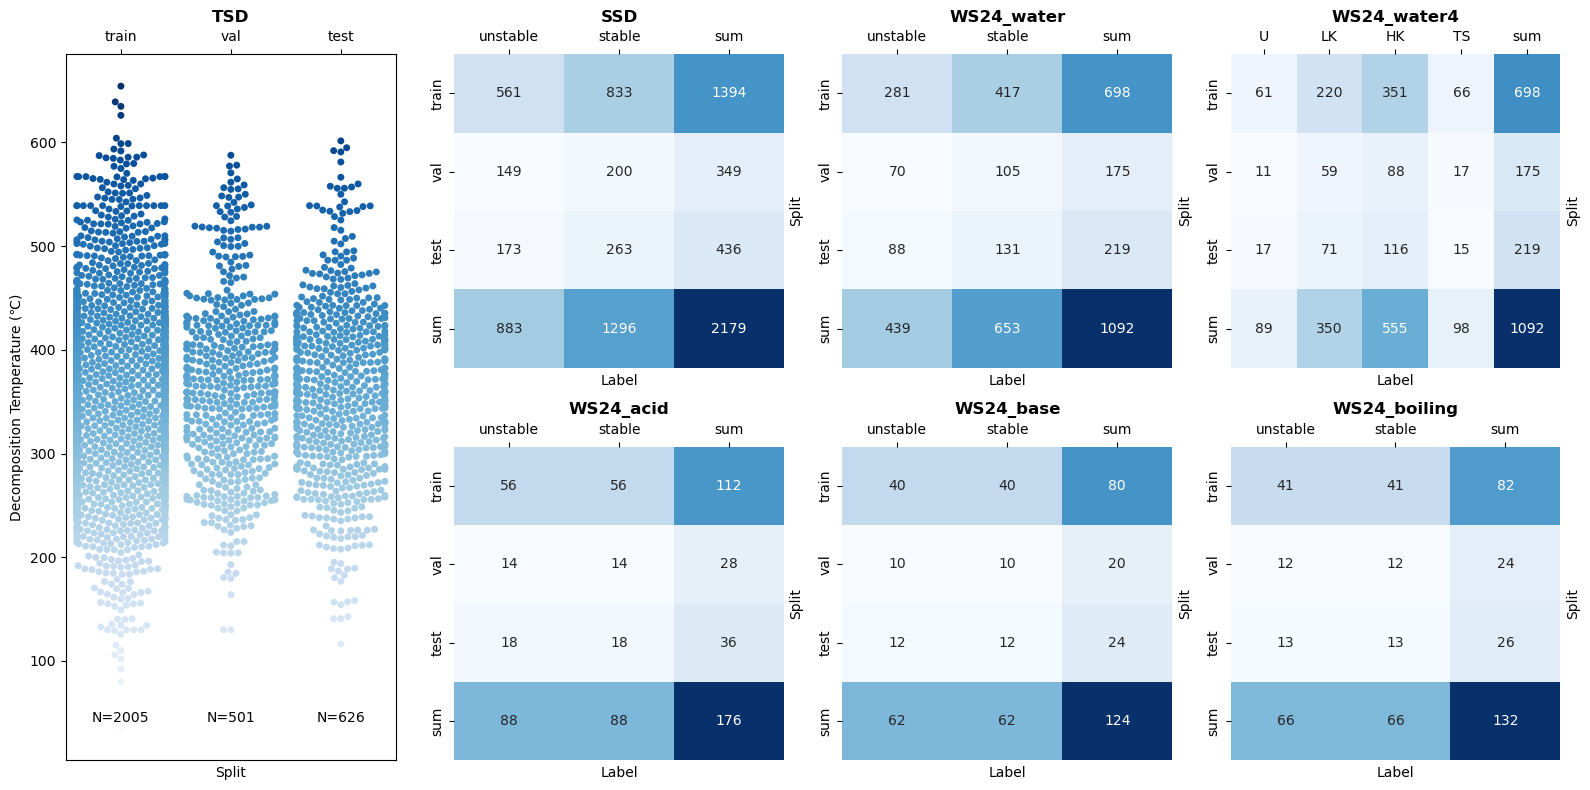

In [7]:
tasks = ["TSD", "SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]

def generate_confusion_matrix(true_labels, pred_labels, true_classes, pred_classes):
    conf_matrix = pd.DataFrame(0, index=true_classes, columns=pred_classes)
    for true_label, pred_label in zip(true_labels, pred_labels):
        conf_matrix.loc[true_label, pred_label] += 1
    return conf_matrix

# 初始化图形
fig = plt.figure(figsize=(16, 8))
nrows = 2
ncols = 4
gs = gridspec.GridSpec(nrows, ncols, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

# 绘制回归数据的swarmplot，占用第一个和第二个位置
ax_reg = plt.subplot(gs[:, 0])
# sns.stripplot(data=dfs["TSD"]["total"], x='Partition', y='Label', ax=ax_reg, 
#               hue='Label', palette='Blues', legend=False)
sns.swarmplot(data=dfs["TSD"]["total"], x='Partition', y='Label', ax=ax_reg, 
              hue='Label', palette='Blues', legend=False)
ax_reg.set_title('TSD', fontweight='bold')
ax_reg.set_xlabel('Split')
ax_reg.set_ylabel('Decomposition Temperature (℃)')
ax_reg.xaxis.set_ticks_position('top')
# ax_reg.tick_params(axis='y', rotation=90)
ax_reg.grid(False)

# 计算每个分组的样本数量并添加标注
y_min, y_max = ax_reg.get_ylim()

grouped_data = dfs["TSD"]["total"].groupby('Partition').size()
for i in range(len(grouped_data)):
    count = grouped_data[dfs["TSD"]["total"]['Partition'].unique()[i]]
    ax_reg.text(i, y_min + (y_max - y_min)*0.05, f'N={count}', ha='center', va='bottom')

# 计算并绘制分类数据的混淆矩阵
for i, task in enumerate(tasks[1:]):
    row = i // (ncols - 1)
    col = i % (ncols - 1) + 1
    # print(row, col)
    sub_df = dfs[task]["total"]
    ax = plt.subplot(gs[row, col])

    if len(sub_df["Label"].unique()) == 4:
        labels = list(class_map_4.values())
    else:
        labels = list(class_map_2.values())
    conf_matrix_df = generate_confusion_matrix(sub_df['Partition'], sub_df['Label'],  
                                               sub_df['Partition'].unique(), labels)
    conf_matrix_df["sum"] = conf_matrix_df.sum(axis=1)
    conf_matrix_df = pd.concat([conf_matrix_df, pd.DataFrame([conf_matrix_df.sum(axis=0)], index=['sum'])], axis=0)

    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(task, fontweight='bold')
    # if row == nrows-1:
    #     ax.set_xlabel('Label')
    # if col == ncols-1:
    #     ax.set_ylabel('Split')
    ax.set_xlabel('Label')
    ax.set_ylabel('Split')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_label_position('right')
    # ax.tick_params(axis='x', rotation=45)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout()
plt.savefig(fig_dir/'dataset_distribution.tif', dpi=96)
plt.show()

## Extracting the insertion of amoung datasets analyziing their correlations

In [6]:
def calculate_cramers_v(var1, var2):
    """
    Calculate Cramér's V
    
    Parameters:
    var1: 1D array or list, values of categorical variable
    var2: 1D array or list, values of categorical variable
    
    Returns:
    Cramér's V
    """
    
    contingency_table = pd.crosstab(var1, var2)
    chi2_stat, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2_stat / n
    k = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(phi2 / k)
    return cramers_v


def calculate_eta_squared(continuous_var, categorical_var):
    """
    Calculate Eta squared (Eta Squared)
    
    Parameters:
    continuous_var: 1D array or list, values of continuous variable
    categorical_var: 1D array or list, values of categorical variable
    
    Returns:
    Eta squared
    """
    continuous_var = np.array(continuous_var)
    categorical_var = np.array(categorical_var)
    if len(continuous_var) != len(categorical_var):
        raise ValueError("The lengths of the two variables must be the same")

    # Standardize continuous variable
    scaler = StandardScaler()
    standardized_continuous_var = scaler.fit_transform(continuous_var.reshape(-1, 1)).flatten()

    # Encode categorical variable
    encoder = LabelEncoder()
    encoded_cat_var = encoder.fit_transform(categorical_var)

    # Calculate total sum of squares
    mean_overall = np.mean(standardized_continuous_var)
    ss_total = np.sum((standardized_continuous_var - mean_overall) ** 2)

    # Calculate between-group sum of squares
    categories = np.unique(encoded_cat_var)
    ss_between = np.sum([
        len(standardized_continuous_var[encoded_cat_var == cat]) * 
        (np.mean(standardized_continuous_var[encoded_cat_var == cat]) - mean_overall) ** 2
        for cat in categories
    ])
    ss_within = np.sum([
        np.sum((standardized_continuous_var[encoded_cat_var == cat] - np.mean(standardized_continuous_var[encoded_cat_var == cat])) ** 2)
        for cat in categories
    ])
    # Calculate Eta squared
    eta_squared = ss_between / ss_total
    return eta_squared


In [7]:
tasks = ["TSD", "SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]
task_types = ["regression", "classification", "classification", "classification", "classification", "classification", "classification"]

corr = []
for task_i, task_tp_i in zip(tasks, task_types):
    corr_row = []
    for task_j, task_tp_j in zip(tasks, task_types):
        if task_i == task_j:
            corr_row.append(1)
            continue
        df_i = dfs[task_i]["total"].reset_index().drop(columns=["Partition"])
        df_j = dfs[task_j]["total"].reset_index().drop(columns=["Partition"])

        df_i = df_i.rename(columns={"Label": f"{task_i}Label"}).copy()
        df_j = df_j.rename(columns={"Label": f"{task_j}Label"}).copy()
        intersection_df = df_i.merge(df_j, on="MofName", how="inner")
        print(f"{task_i} vs {task_j}: {len(intersection_df)}")
        if len(intersection_df) == 0:
            corr_row.append(0)
            continue
        all_task_tps = [task_tp_i, task_tp_j]
        if "regression" in all_task_tps:
            all_labels = [intersection_df[f"{task_i}Label"], intersection_df[f"{task_j}Label"]]
            reg_labels = all_labels[all_task_tps.index("regression")]
            clf_labels = all_labels[all_task_tps.index("classification")]
            corr_coef = calculate_eta_squared(reg_labels, clf_labels)
        else:
            corr_coef = calculate_cramers_v(intersection_df[f"{task_i}Label"], intersection_df[f"{task_j}Label"])
        corr_row.append(corr_coef)
    corr.append(corr_row)

corr_df = pd.DataFrame(corr, index=tasks, columns=tasks)
corr_df

TSD vs SSD: 1163
TSD vs WS24_water: 244
TSD vs WS24_water4: 244
TSD vs WS24_acid: 36
TSD vs WS24_base: 25
TSD vs WS24_boiling: 23
SSD vs TSD: 1163
SSD vs WS24_water: 125
SSD vs WS24_water4: 125
SSD vs WS24_acid: 20
SSD vs WS24_base: 14
SSD vs WS24_boiling: 10
WS24_water vs TSD: 244
WS24_water vs SSD: 125
WS24_water vs WS24_water4: 1092
WS24_water vs WS24_acid: 176
WS24_water vs WS24_base: 124
WS24_water vs WS24_boiling: 132
WS24_water4 vs TSD: 244
WS24_water4 vs SSD: 125
WS24_water4 vs WS24_water: 1092
WS24_water4 vs WS24_acid: 176
WS24_water4 vs WS24_base: 124
WS24_water4 vs WS24_boiling: 132
WS24_acid vs TSD: 36
WS24_acid vs SSD: 20
WS24_acid vs WS24_water: 176
WS24_acid vs WS24_water4: 176
WS24_acid vs WS24_base: 57
WS24_acid vs WS24_boiling: 40
WS24_base vs TSD: 25
WS24_base vs SSD: 14
WS24_base vs WS24_water: 124
WS24_base vs WS24_water4: 124
WS24_base vs WS24_acid: 57
WS24_base vs WS24_boiling: 29
WS24_boiling vs TSD: 23
WS24_boiling vs SSD: 10
WS24_boiling vs WS24_water: 132
WS2

,TSD,SSD,WS24_water,WS24_water4,WS24_acid,WS24_base,WS24_boiling
TSD,1.000000e+00,5.050924e-07,0.004202,0.007212,0.019462,0.000101,0.131554
SSD,5.050924e-07,1.000000e+00,0.022629,0.230155,0.366007,0.155700,0.000000
WS24_water,4.202327e-03,2.262855e-02,1.000000,1.000000,0.493007,0.558726,0.536142
WS24_water4,7.211835e-03,2.301545e-01,1.000000,1.000000,0.595029,0.704735,0.743696
WS24_acid,1.946238e-02,3.660072e-01,0.493007,0.595029,1.000000,0.734265,0.450749
WS24_base,1.006661e-04,1.556998e-01,0.558726,0.704735,0.734265,1.000000,0.633838
WS24_boiling,1.315545e-01,0.000000e+00,0.536142,0.743696,0.450749,0.633838,1.000000


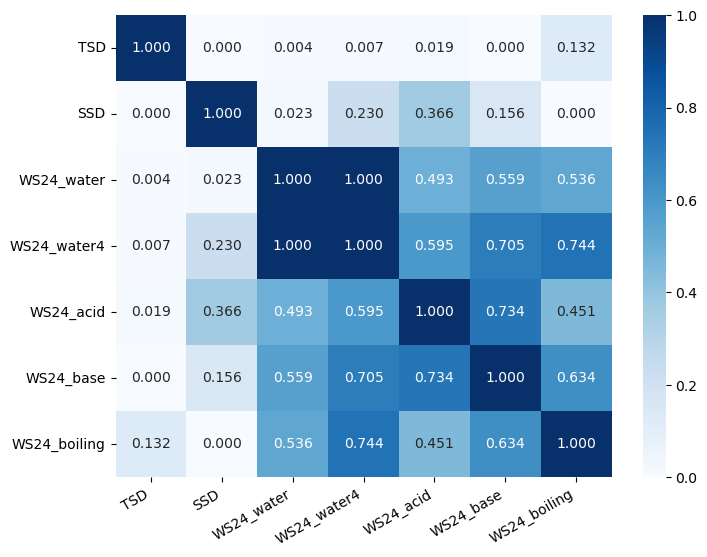

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='Blues', ax=ax, cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

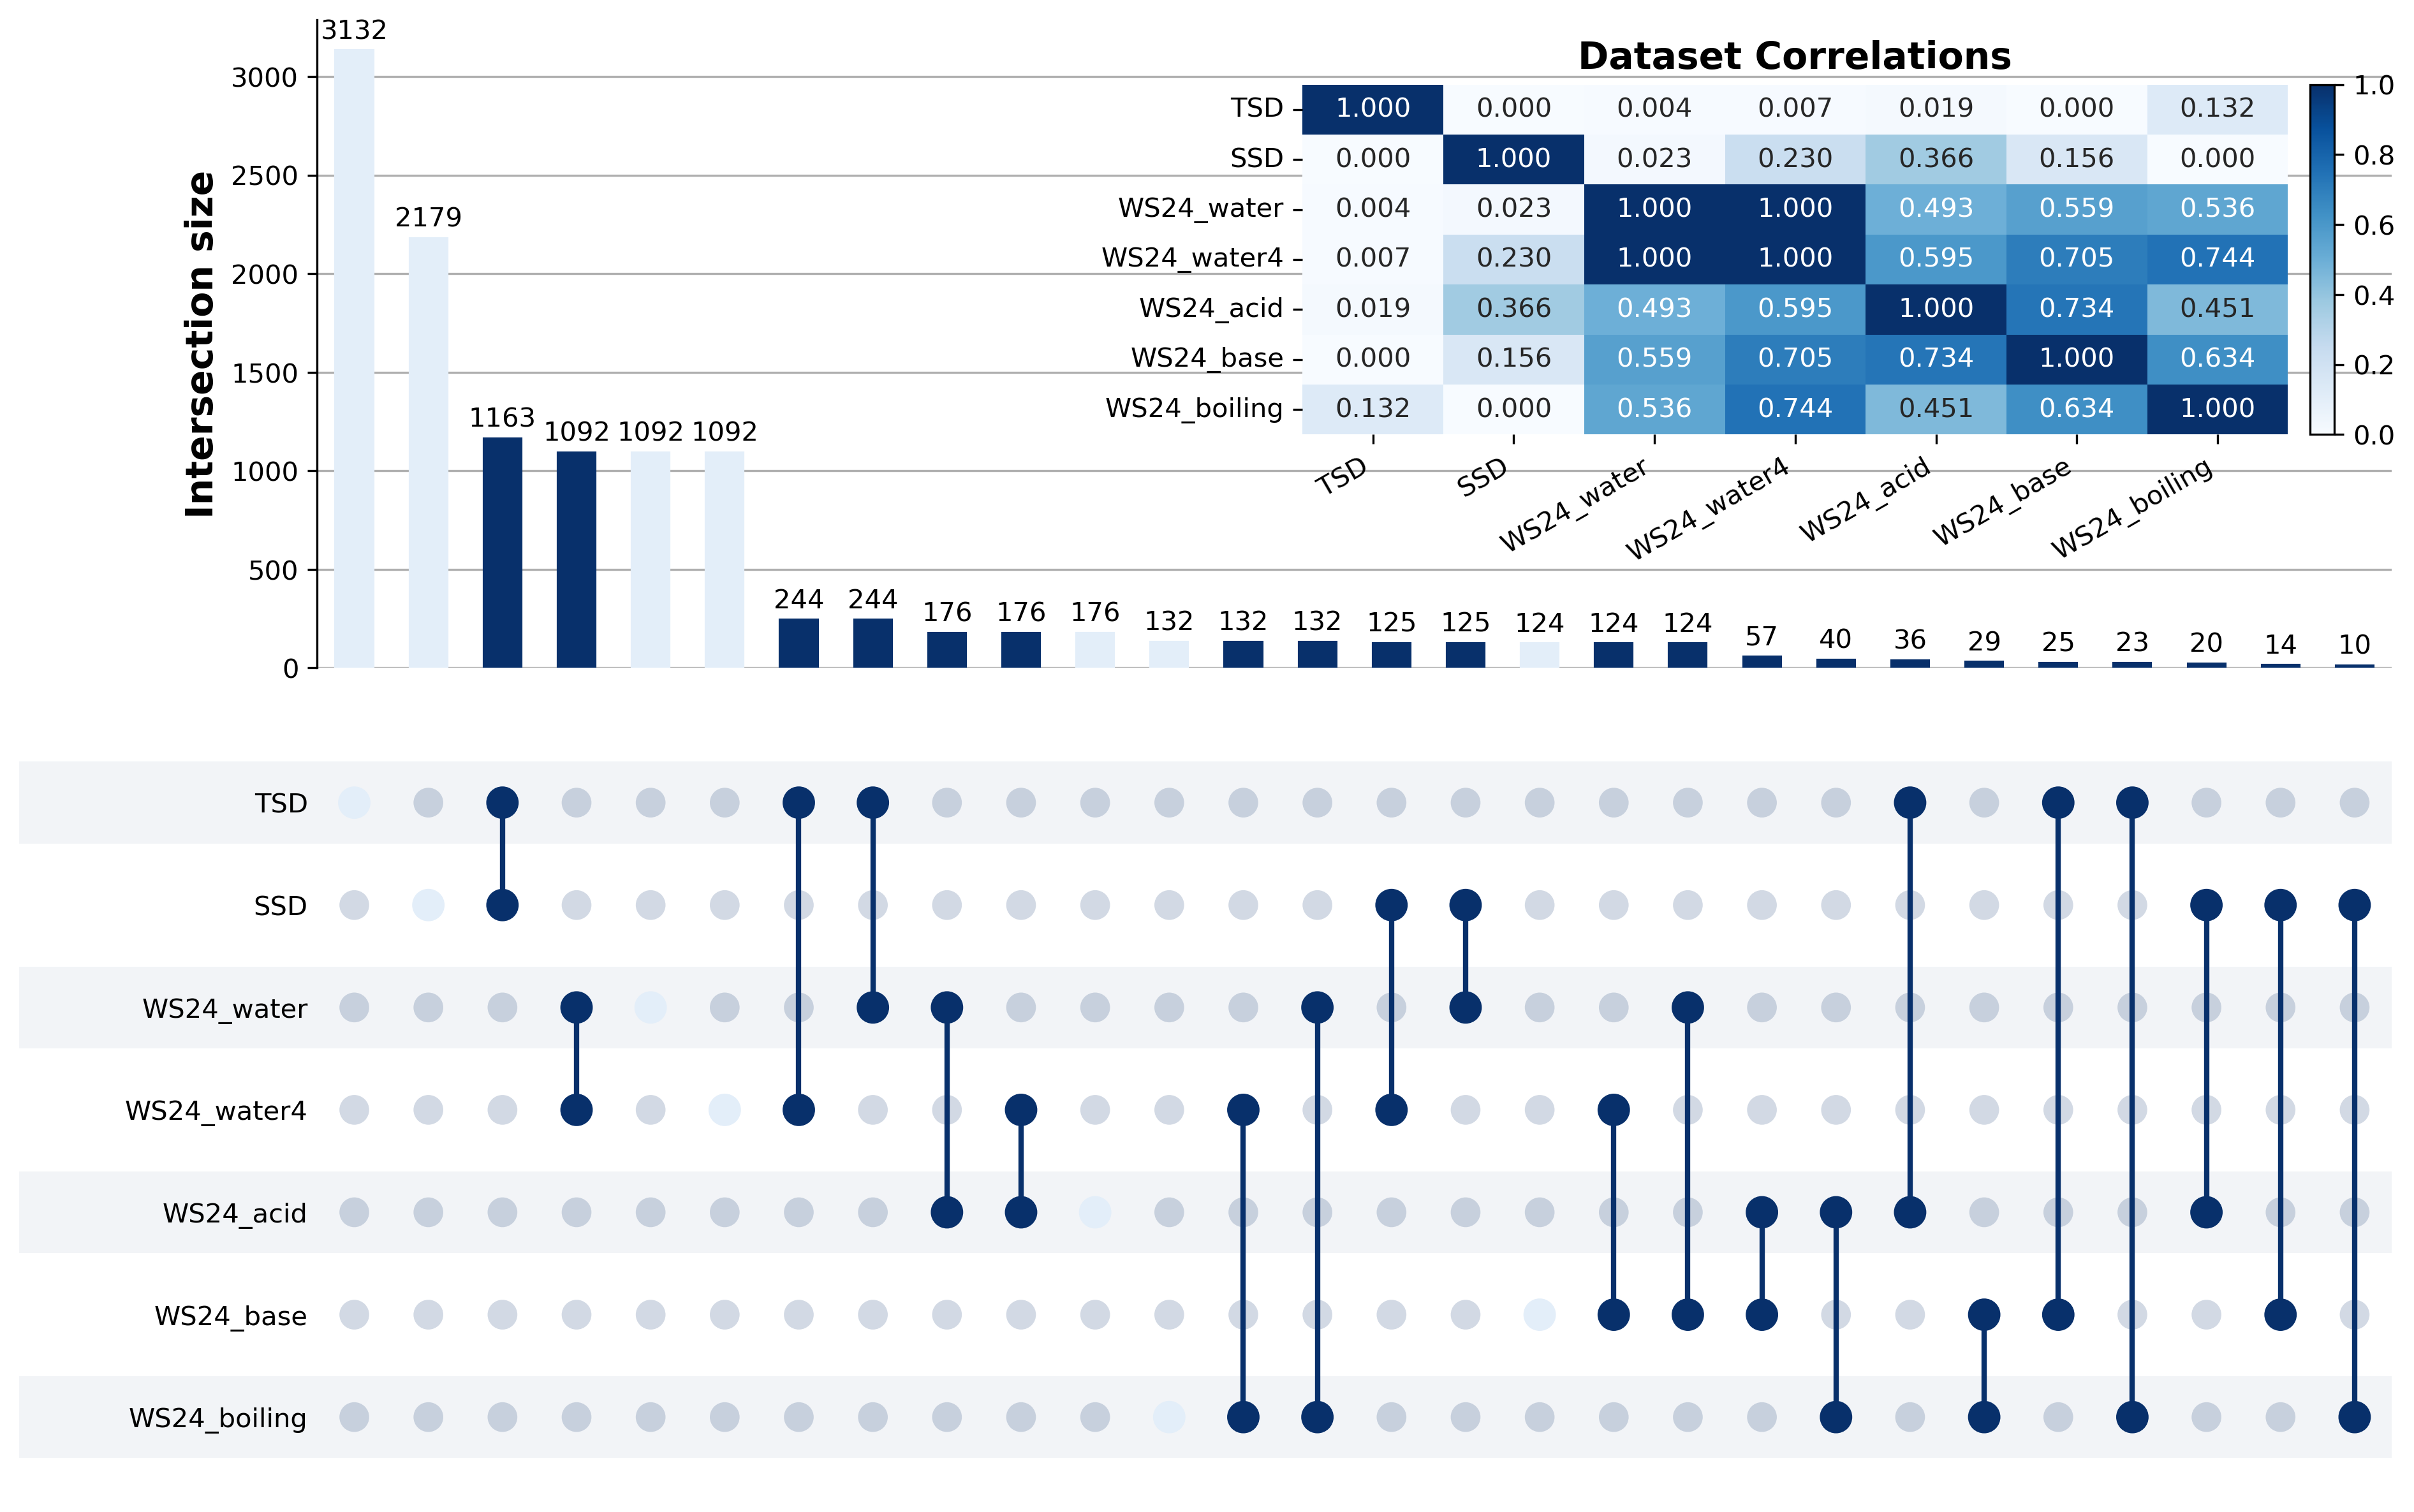

In [11]:
tasks = ["TSD", "SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]
all_cif_ids =  {task: dfs[task]["total"].index for task in tasks}
all_samples = set().union(*all_cif_ids.values())
data = []
for sample in all_samples:
    row = []
    for task in tasks:
        if sample in all_cif_ids[task]:
            row.append(True)
        else:
            row.append(False)
    # if sum(row) == 1:
    #     continue
    if sum(row) >= 2:
        # Get indices of `True`
        true_indices = [i for i, value in enumerate(row) if value]

        # Generate all possible combinations of indices with only one `True`
        one_true_combinations = list(combinations(true_indices, 1))
        two_true_combinations = list(combinations(true_indices, 2))

        for combo in two_true_combinations:
            # Create a list with all `False`
            new_list = [False] * len(row)
            # Set selected indices in the combination to `True`
            for index in combo:
                new_list[index] = True
            data.append(new_list + [sum(new_list)])
        for combo in one_true_combinations:
            # Create a list with all `False`
            new_list = [False] * len(row)
            # Set selected indices in the combination to `True`
            for index in combo:
                new_list[index] = True
            data.append(new_list + [sum(new_list)])
        continue
    # elif row[2] and sum(row[3:]) == 1:
    #     continue
    data.append(row + [sum(row)])

upset_data = pd.DataFrame(data, columns=tasks + ['count'])
upset_data.set_index(tasks, inplace=True)
# upset_data.sort_index(ascending=True, inplace=True)
# upset_data.sort_values(by='count', ascending=False, inplace=True)

# Create Upset Plot
# fig, ax = plt.subplots(1, 1, figsize=(20, 6), dpi=300)
upset = UpSet(upset_data, subset_size='count', sort_by='cardinality', sort_categories_by="-input",
              facecolor="#08306b", show_counts=True, totals_plot_elements=0)
upset.style_subsets(max_degree=1, facecolor="#e3eef9")
plot_dict = upset.plot()
intersections_ax = plot_dict['intersections']
intersections_ax.set_ylabel(intersections_ax.get_ylabel(), fontsize=14, fontweight='bold')


ax_inset = inset_axes(intersections_ax, width="50%", height="60%", loc='upper right', 
                      bbox_to_anchor=(0, 0., 0.95, 0.9), bbox_transform=intersections_ax.transAxes, borderpad=0)
sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='Blues', ax=ax_inset, cbar=False)

ax_inset.set_xticklabels(ax_inset.get_xticklabels(), rotation=30, horizontalalignment='right')
ax_inset.set_title('Dataset Correlations', fontsize=14, fontweight='bold')

# Add colorbar for the inset plot
inset_colorbar = inset_axes(ax_inset, width="5%", height="100%", loc='right', 
                            bbox_to_anchor=(0.55, 0, 0.5, 1), bbox_transform=ax_inset.transAxes, borderpad=0.1)

plt.colorbar(ax_inset.collections[0], cax=inset_colorbar)

# intersections_ax.grid(False)
fig = intersections_ax.figure
fig.set_size_inches(16, 10)
fig.figure.set_dpi(300)
fig.savefig(fig_dir/'dataset_intersections.tif', bbox_inches='tight')
plt.show()